In [135]:
import numpy as np
import numpy.random as rd
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import combinations, chain
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import lasso_path

In [2]:
pX = pd.read_csv('prostate/prostate.csv')
pY = pX.iloc[:,-1]
pX = np.array(pX.iloc[:,1:6034])

In [3]:
shuf = np.arange(pX.shape[0])
rd.shuffle(shuf)

In [4]:
start = [0, 20, 40, 60, 80]
end = [20, 40, 60, 80, 102]

### PCA

In [5]:
prob = np.zeros(pY.shape[0])
for i in range(5):
    test_X = pX[shuf[start[i]:end[i]],:]
    test_Y = pY[shuf[start[i]:end[i]]]
    train_ind = np.setdiff1d(np.arange(pX.shape[0]),shuf[start[i]:end[i]])
    train_X = pX[train_ind,:]
    train_Y = pY[train_ind]

    pca = IncrementalPCA(n_components=20)
    inter_train_X = pca.fit_transform(train_X)
    model = LogisticRegression(solver='liblinear')
    model.fit(inter_train_X, train_Y)

    inter_test_X = pca.fit_transform(test_X)
    proba_res = model.predict_proba(inter_test_X)
    prob[shuf[start[i]:end[i]]] = proba_res[:,1] - proba_res[:,0]
    
fpr_1, tpr_1, thresholds = roc_curve(pY, prob, pos_label = 1)

C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
D:\Anaconda\envs\learn\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
D:\Anaconda\envs\learn\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
D:\Anaconda\envs\lea

### Forward

In [40]:
lreg = LogisticRegression()
sfs1 = sfs(lreg,n_features_to_select=20, direction='forward', n_jobs=-1)
model = sfs1.fit(np.array(pX), np.array(pY))

In [42]:
res_ind = model.support_
pX_re = pX[:,res_ind]

In [44]:
prob = np.zeros(pY.shape[0])
for i in range(5):
    test_X = pX_re[shuf[start[i]:end[i]],:]
    test_Y = pY[shuf[start[i]:end[i]]]
    train_ind = np.setdiff1d(np.arange(pX.shape[0]),shuf[start[i]:end[i]])
    train_X = pX_re[train_ind,:]
    train_Y = pY[train_ind]

    model = LogisticRegression()
    model = model.fit(train_X, train_Y)

    proba_res = model.predict_proba(test_X)
    prob[shuf[start[i]:end[i]]] = proba_res[:,1] - proba_res[:,0]
    

fpr_2, tpr_2, thresholds = roc_curve(pY, prob, pos_label = 1)

### LASSO Path

In [49]:
_, coef_path, _=lasso_path(pX,pY)

In [60]:
coef_path[:,1]

array([-0., -0., -0., ..., -0., -0., -0.])

In [62]:
i = 0
while i < coef_path.shape[1]:
    if np.sum(coef_path[:,i]!=0) == 20:
        break
    i=i+1

In [65]:
ind_remain = coef_path[:,i]!=0

In [66]:
pX_remain = pX[:,ind_remain]

In [67]:
prob = np.zeros(pY.shape[0])
for i in range(5):
    test_X = pX_remain[shuf[start[i]:end[i]],:]
    test_Y = pY[shuf[start[i]:end[i]]]
    train_ind = np.setdiff1d(np.arange(pX.shape[0]),shuf[start[i]:end[i]])
    train_X = pX_remain[train_ind,:]
    train_Y = pY[train_ind]
    
    model = LogisticRegression(solver='liblinear')
    model.fit(train_X, train_Y)
    
    proba_res = model.predict_proba(test_X)
    prob[shuf[start[i]:end[i]]] = proba_res[:,1] - proba_res[:,0]

fpr3, tpr3, thresholds = roc_curve(pY, prob, pos_label = 1)


### Chatterjee Correlation

In [6]:
def chatterjee(x,y):
    n=len(x)
    df=pd.DataFrame({'X':x,'Y':y})
    df['rank_x']=df['X'].rank()
    df['rank_y']=df['Y'].rank()
    df=df.sort_values(by='rank_x')
    sum_term1=df['rank_y'].diff().abs().sum()
    sum_term2=((df['rank_y']-1)*(n+1-df['rank_y'])).sum()
    #return 1-(n*sum_term1)/(2*sum_term2)
    return (1-3*sum_term1/(pow(n,2)-1))

In [7]:
cor=np.zeros(6033)
for i in range(6033):
    temp_x=pX[:,i]
    cor[i]=chatterjee(temp_x,pY)
index = np.argsort(-cor)

In [8]:
n_feature = 20
pX_rem = pX[:,index[0:n_feature]]

Text(0.5, 1.0, 'ROC Curve of Logistic Regression(Significant Variable Included)')

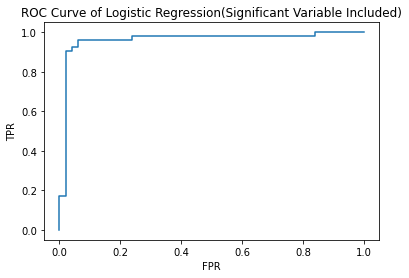

In [11]:
prob = np.zeros(pY.shape[0])
for i in range(5):
    test_X = pX_rem[shuf[start[i]:end[i]],:]
    test_Y = pY[shuf[start[i]:end[i]]]
    train_ind = np.setdiff1d(np.arange(pX.shape[0]),shuf[start[i]:end[i]])
    train_X = pX_rem[train_ind,:]
    train_Y = pY[train_ind]
    
    model = LogisticRegression(solver='liblinear')
    model.fit(train_X, train_Y)
    
    proba_res = model.predict_proba(test_X)
    prob[shuf[start[i]:end[i]]] = proba_res[:,1] - proba_res[:,0]

fpr4, tpr4, thresholds = roc_curve(pY, prob, pos_label = 1)
plt.plot(fpr4, tpr4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve of Logistic Regression(Significant Variable Included)')

### No Model Selection

In [99]:
prob = np.zeros(pY.shape[0])
for i in range(5):
    test_X = pX[shuf[start[i]:end[i]],:]
    test_Y = pY[shuf[start[i]:end[i]]]
    train_ind = np.setdiff1d(np.arange(pX.shape[0]),shuf[start[i]:end[i]])
    train_X = pX[train_ind,:]
    train_Y = pY[train_ind]
    
    model = LogisticRegression(solver='liblinear')
    model.fit(train_X, train_Y)
    
    proba_res = model.predict_proba(test_X)
    prob[shuf[start[i]:end[i]]] = proba_res[:,1] - proba_res[:,0]

fpr5, tpr5, thresholds = roc_curve(pY, prob, pos_label = 1)

### ROC for Model Selection

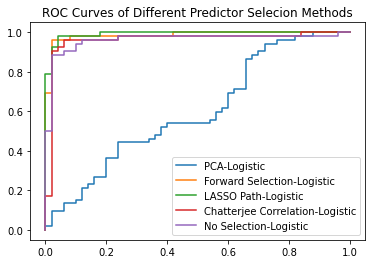

In [104]:
plt.plot(fpr_1, tpr_1, label='PCA-Logistic')
plt.plot(fpr_2, tpr_2, label='Forward Selection-Logistic')
plt.plot(fpr3, tpr3, label='LASSO Path-Logistic')
plt.plot(fpr4, tpr4, label='Chatterjee Correlation-Logistic')
plt.plot(fpr5, tpr5, label='No Selection-Logistic')
plt.legend()
plt.title('ROC Curves of Different Predictor Selecion Methods')
plt.show()

### Significant Predictors

In [78]:
for_imp = np.arange(6033)[res_ind]


In [79]:
las_imp = np.arange(6033)[ind_remain]

In [80]:
cha_imp = index[1:20]

In [88]:
np.intersect1d(np.intersect1d(for_imp, las_imp),cha_imp)

array([5015], dtype=int64)

Text(0.5, 1.0, 'Chatterjee Correlations With the Response')

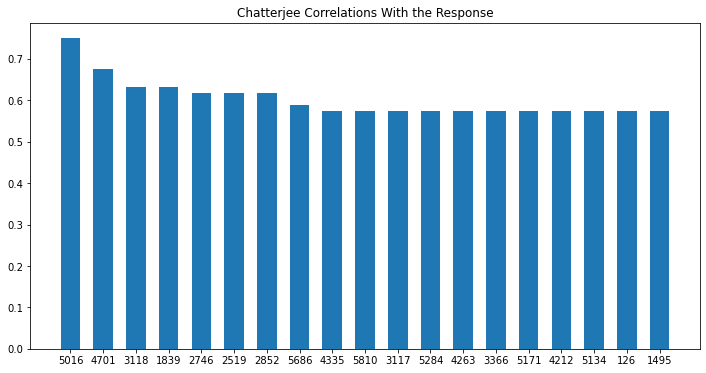

In [122]:
plt.figure(figsize=(12,6))
plt.bar((cha_imp+1).astype(str), cor[cha_imp],width=0.6)
plt.title('Chatterjee Correlations With the Response')

In [107]:
set(cha_imp)

{125,
 1494,
 1838,
 2518,
 2745,
 2851,
 3116,
 3117,
 3365,
 4211,
 4262,
 4334,
 4700,
 5015,
 5133,
 5170,
 5283,
 5685,
 5809}

In [89]:
all_variable = np.union1d(np.union1d(for_imp,las_imp),cha_imp)

In [93]:
cha_cor = np.zeros((len(all_variable),len(all_variable)))
for i in range(len(all_variable)):
    for j in range(len(all_variable)):
        cha_cor[i,j] = chatterjee(pX[:,all_variable[i]],pX[:,all_variable[j]]

In [97]:
for i in range(len(all_variable)):
    cha_cor[i,i] = 0

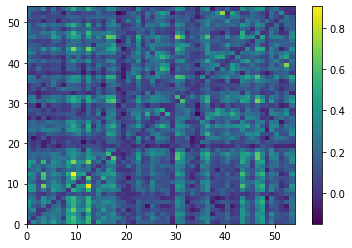

In [98]:
heatmap = plt.pcolor(cha_cor)
plt.colorbar(heatmap)

In [134]:
selected = rd.sample(range(6033),500)

In [128]:
np.arange(3).tolist()

[0, 1, 2]